In [10]:
import pandas as pd
import numpy as np
import networkx as nx

from sklearn.utils import extmath
from scipy.spatial.distance import pdist, squareform
from scipy import sparse, stats, spatial
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data_folder = './data/Main/'

# 1. Preparing the datasets

## 1.1. Loading

In [4]:
#### Loading 'tracks' dataset
tracks = pd.read_csv(data_folder+'tracks.csv', 
                        index_col=0, encoding='utf-8', low_memory=False)
# Mapping trackID to numeric ID
# Getting unique trackID
unique_trackID = tracks.trackID.unique()
# Creating a dictionary to assign numeric ID to each trackID
dict_trackID = dict(zip(unique_trackID, range(unique_trackID.size)))
# Mapping trackID to numeric ID using 'dict_trackID' dictionary
tracks['trackID'] = tracks.trackID.map(dict_trackID)

print(tracks.shape)
tracks.head(3)

(64500, 14)


,trackID,trackTitle,artistName,trackPopularity,releaseDate,artistFollowers,topGenre1,topGenre2,artistID,albumID,songID,audio_Duration_ms,set_subset,set_split
0,0,The Room Of Stairs,Harold Budd,11.0,2000,30414.0,Electronic/Dance,Classical,3uOCouLFR4bVx0XeiQJSbl,3jq7b66l8MswqDmi0mxzjq,SOAAADD12AB018A9DD,321133,medium,train
1,1,(I'm Gonna Start) Living Again If It Kills Me,Dave Edmunds,5.0,1981,28604.0,Rock,Blues,65Gh3BfK84aTIugiRCgLBA,0upTl2RUS4gmStWBlXjt9l,SOAAADE12A6D4F80CC,199088,medium,train
2,2,KRYSAR (LIVE),LANDA DANIEL,15.0,2003,NaN,NaN,NaN,6rSpV5hdCNJ4v1i602nj22,7uvLu2RAki7aKiASSxJPzi,SOAAADF12A8C13DF62,200880,medium,train


In [5]:
### Loading playlists dataset
user_profile = pd.read_csv(data_folder+'userProfile.csv', 
                        index_col=0, encoding='utf-8', low_memory=False)

# Keeping only tracks that exists in tracks dataframe
user_profile = user_profile[user_profile.trackID.isin(list(dict_trackID.keys()))]

print(user_profile.shape)
user_profile.head(3)

/root/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(4911782, 4)


,userID,songID,counts,trackID
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,2ECKXkpPAxky87ohawpaeD
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1,5WjXULJvSlMxuies9diz1Q
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1,1bqi9YEdZweX9H6JuSQ6Qw


In [6]:
### Mapping userID to numeric ID
# getting unique userID
unique_userID = user_profile.userID.unique()
# Creating a dictionary to assign numeric ID to current user ID
dict_userID = dict(zip(unique_userID, range(unique_userID.size)))
# Mapping userID using prepared dictionary
user_profile.userID = user_profile.userID.map(dict_userID)
# Mapping trackID to numeric ID using 'dict_trackID' dictionary
user_profile.trackID = user_profile.trackID.map(dict_trackID)
user_profile = user_profile[['userID', 'trackID', 'counts']]

print(user_profile.shape)

(4911782, 3)


In [7]:
# Loading 'librosa_features' dataset
features = pd.read_csv(data_folder+'librosa_features.csv', 
                        index_col=0, header=[0,1,2], encoding='utf-8', low_memory=False)

# Converting multi-index columns to flat index
features.columns = [ '_'.join(x) for x in features.columns ]

# Filter Librosa feature to the songs that exists in tracks dataframe
features = features[features.index.isin(list(dict_trackID.keys()))]

# Mapping trackID to numeric ID using 'dict_trackID' dictionary
features.index = features.index.map(dict_trackID).astype(int)

print(features.shape)
features.head(3)

(64500, 518)


,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,0.720673,4.240027,-0.618995,0.426698,-0.226265,-0.209698,-0.317341,-1.345874,-0.586116,-0.931247,...,0.084099,0.017905,0.017880,3.022421,0.400879,0.093924,0.078125,0.030273,1.610670,0.054095
1,-0.370662,-0.287299,1.182948,-0.952800,-0.790715,-0.504890,-0.491160,0.696574,0.054538,0.780068,...,0.127805,0.020186,0.023055,13.629067,0.286621,0.046816,0.042969,0.008301,2.550661,0.024498
2,-0.769198,-0.571088,-0.860308,0.437645,-1.027899,1.226321,-0.928717,1.680385,-1.276514,-0.994085,...,0.084305,0.018808,0.020520,10.252457,0.222168,0.053373,0.049316,0.013184,2.536385,0.023678


## 1.2. Filtering to 12,000 songs

In [8]:
# Filtering tracks to be left by only small subset
tracks_s = tracks[tracks.set_subset=='small']#.iloc[:2000,:]
print('Tracks dataframe shape after filtering: ',tracks_s.shape)

# Filtering features based on filtered 'tracks_s' dataframe
features_s  = features[features.index.isin(tracks_s.trackID)]
# Filling NAs
features_s = features_s.fillna(0)
print('Features dataframe after ',features_s.shape)

Tracks dataframe shape after filtering:  (12900, 14)
Features dataframe after  (12900, 518)


In [41]:
# Saving the filtered tracks dataframe
tracks_s.to_csv(data_folder+'tracks_filtered.csv', encoding='utf-8', index=True)
# Saving the filtered features dataframe
features_s.to_csv(data_folder+'features_filtered.csv', encoding='utf-8', index=True)

In [51]:
# Filtering the user_profile to only the ones that presented in the nodes
user_profile_s = user_profile[user_profile.trackID.isin(nodes_name)]

# Sorting based on User id
user_profile_s = user_profile_s.sort_values(by=['userID'])

print(user_profile_s.shape)
user_profile_s.head()

(1083790, 3)


,userID,trackID,counts
26,4,38844,8
27,5,8362,1
29,6,5431,2
32,7,8362,3
41,7,53398,1


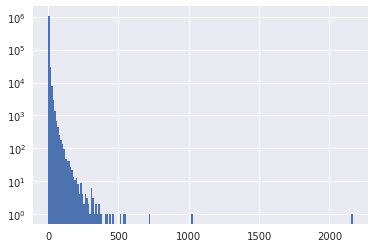

In [52]:
plt.hist(user_profile_s.counts.values, bins=200)
plt.yscale('log')
plt.show()

In [53]:
def map_counts(df):
    '''
    Gets data for each user and returns the mapped counts
    
        Input:
            - df: Pandas DataFrame
        Output:
            - mapped_df: mapped counts as a dataframe
    '''
    global pbar
    pbar.update(df.shape[0])
    
    # Getting the 60% percentile of the data for one user
    percentile = np.percentile(df.loc[: ,'counts'].values, 60)
    # Map counts larger than the 60-percentile to 3 (user likes them very much)
    # and smaller than percentile to 1 (user likes them)
    df.loc[df.counts>percentile, 'counts'] = 3
    df.loc[df.counts<=percentile, 'counts'] = 1
    
    return df

In [54]:
# This cell had ran before and the result was saved in 'user_profile_mapped_s' csv file
'''from tqdm import tqdm

total = user_profile_s.shape[0]
pbar = tqdm(total=total)

# Applying mapping counts
user_profile_s = user_profile_s.groupby(by=['userID']).apply(lambda x: map_counts(x))

pbar.close()'''

"from tqdm import tqdm\n\ntotal = user_profile_s.shape[0]\npbar = tqdm(total=total)\n\n# Applying mapping counts\nuser_profile_s = user_profile_s.groupby(by=['userID']).apply(lambda x: map_counts(x))\n\npbar.close()"

In [ ]:
# Saving the mapped user_profile
#user_profile_s.to_csv(data_folder+'user_profile_mapped_s.csv', encoding='utf-8', index=True)

In [55]:
# Loading the saved mapped 'user_profile'
user_profile_s = pd.read_csv(data_folder+'user_profile_mapped_s.csv', encoding='utf-8', index_col=0)

/root/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# 2. Songs similarity network based on Librosa Features

In [15]:
#######################################################################################################
###### Standardizing features, since the algorithm works better with standardized features #######
#######################################################################################################

# Standardizing the 'features' dataframe
scaler_features = StandardScaler()
features_scaled = scaler_features.fit_transform(features_s)
features_scaled = pd.DataFrame(features_scaled, index=features_s.index, columns=features_s.columns)

# Compute the distance between the tracks for creating adjacency matrix
### Using pdist to calculate the pairwise distance between each track
distances = spatial.distance.pdist(features_scaled, metric='cosine')
distances = spatial.distance.squareform(distances)

print(distances.shape)

(12900, 12900)


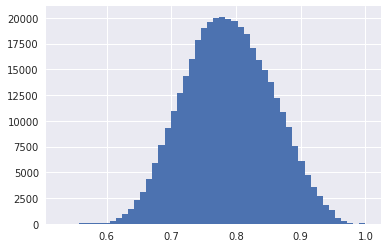

In [16]:
_ = plt.hist(weights[weights > 0].reshape(-1), bins=50)

In [17]:
# Computing weights matrix
kernel_width = distances.mean()
weights = np.exp(-1*(distances**2/(kernel_width**2)))
#Setting the diagonal to zero
np.fill_diagonal(weights, 0)

# First step of sparsifying: Based on weights
sp_thr = 0.1
weights[weights<=sp_thr] = 0

# We sparsify based on outdegree of each node: a[0,:] show out-going edges
### This is because in the algorithms that we will use, 
### ...in-degree contains information that we don't want to lose
Edges = 30
sort_idx = np.argsort(weights, axis=1)
#Leaving all but the 50 strongest edges
for i,index in enumerate(sort_idx):
    weights[i, index[:-Edges]] = 0

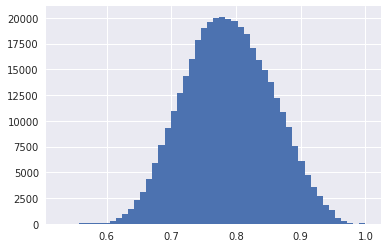

In [18]:
#Displaying the histogram of the distances before sparsifying
plt.hist(weights[weights > 0].reshape(-1), bins=50);

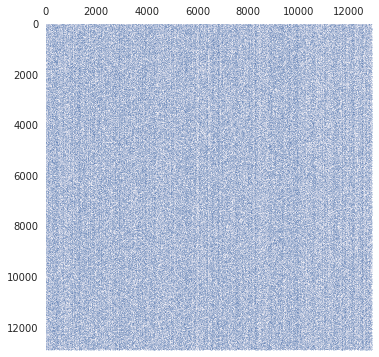

In [19]:
#Plotting first the fully connected network
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
_ = ax.spy(weights, markersize=0.25)
_ = ax.grid(False)

In [20]:
w_ex = weights.reshape(-1)
print('Number of edges in our graph: {}'.format(w_ex[w_ex>0].size))

Number of edges in our graph: 387000


In [43]:
# Saving the weights matrix
np.save('weights_based_on_Librosa.npy', weights)

## 2.2. Creating NetworkX graph

In [46]:
# Getting sparse matrix
weights_sp = sparse.csr_matrix(weights)

# Building a graph from Sparse CSR matrix
G_tracks = nx.from_scipy_sparse_matrix(weights_sp, create_using=nx.DiGraph(), edge_attribute='weight')

# Relabeling the nodes (name of nodes: TrackID)
G_tracks = nx.relabel_nodes(G_tracks, dict(zip(range(len(tracks_s.trackID.values)), tracks_s.trackID.values)))

In [48]:
# Checking if the graph is connected
print(nx.is_strongly_connected(G_tracks))
# Getting the number of Connected components
print('There are {} connected components!'.format(nx.number_strongly_connected_components(G_tracks)))

False
There are 85 connected components!


In [23]:
# Getting connected components
components = []
for component in nx.strongly_connected_components(G_tracks):
    components.append(component)

# Sorting the connected components based on their number of nodes
components.sort(key=lambda x: len(x))

# Creating a subgraph of G_tracks whihc contains selected songs 
### (here 500 songs selected in "creating utility matrix" step)
G_tracks = G_tracks.subgraph(sorted(list(components[-1])))

In [49]:
# Adding meta data to the graph
for node, dic in G_tracks.nodes(data=True):
    G_tracks.node[node]['trackTitle'] = tracks.loc[tracks.trackID==node,'trackTitle'].values[0]
    G_tracks.node[node]['artistName'] = tracks.loc[tracks.trackID==node,'artistName'].values[0]
    G_tracks.node[node]['topGenre'] = tracks.loc[tracks.trackID==node,'topGenre1'].values[0]
    G_tracks.node[node]['audioDuration'] = tracks.loc[tracks.trackID==node,'audio_Duration_ms'].values[0]//1000
    G_tracks.node[node]['trackPopularity'] = tracks.loc[tracks.trackID==node,'trackPopularity'].values[0]

In [50]:
# Saving the similarity NetworkX graph based on Librosa features
nx.write_gpickle(G_tracks, "similarity_based_on_librosa.gpickle")

In [25]:
# Creating a list of nodes names
nodes_name = tracks_s.trackID.values 

nodes_name = nodes_name[np.isin(nodes_name, list(G_tracks.nodes()))]

# 3. Creating songs similarity network extracted from User profile

## 3.1. Creating utility matrix

In [31]:
# Creating a sparse matrix from 'user_profile' dataframe
userID_cat = CategoricalDtype(user_profile_s.userID.unique(), ordered=True)
trackID_cat = CategoricalDtype(nodes_name, ordered=True)

row = user_profile_s.userID.astype(userID_cat).cat.codes
col = user_profile_s.trackID.astype(trackID_cat).cat.codes
sparse_utility = csr_matrix((user_profile_s['counts'], (row, col)), \
                             shape=(userID_cat.categories.size, trackID_cat.categories.size))

# Defining the sparse DataFrame
utility_df = pd.SparseDataFrame(sparse_utility, \
                         index=userID_cat.categories, \
                         columns=trackID_cat.categories, \
                         default_fill_value=0)

utility_df.head()

,5,10,11,21,22,29,41,42,44,46,...,64443,64447,64455,64459,64460,64461,64468,64473,64488,64490
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# Saving sparse CSR matrix
sparse.save_npz(data_folder+"sparse_utility.npz", sparse_utility)

## 3.2. Using SVD decomposition the get user2concepts and songs2concepts matrices

In [33]:
n_components = 50
U, S, V = extmath.randomized_svd(sparse_utility, n_components, n_oversamples=20, n_iter=10, 
                                               power_iteration_normalizer='QR', 
                                               transpose=False, flip_sign=True, random_state=0)

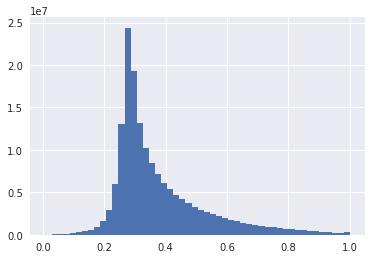

In [34]:
# Compute the distance between the tracks for creating adjacency matrix
### Using pdist to calculate the pairwise distance between each track
distances_h = spatial.distance.pdist(V.T, metric='cosine')
distances_h = spatial.distance.squareform(distances_h)

# Computing weights matrix
kernel_width_h = distances_h.mean()
weights_h = np.exp(-1*(distances_h**2/(kernel_width_h**2)))

#Setting the diagonal to zero
np.fill_diagonal(weights_h, 0)

#Displaying the histogram of the distances before sparsifying
plt.hist(weights_h[weights_h > 0].reshape(-1), bins=50);

In [35]:
### Sparsifying the weights matrix

# First step of sparsifying: Based on weights
sp_thr = 0.2
weights_h[weights_h<=sp_thr] = 0

# We sparsify based on outdegree of each node: a[0,:] show out-going edges
### This is because in the algorithms that we will use, 
### ...in-degree contains information that we don't want to lose
Edges = 30

sort_idx = np.argsort(weights_h, axis=1)
#Leaving all but the 50 strongest edges
for i,index in enumerate(sort_idx):
    weights_h[i, index[:-Edges]] = 0


In [44]:
# Saving the weights_h matrix
np.save(data_folder+'weights_based_on_userProfile.npy', weights_h)

## 3.3. Creating NetworkX graph

In [56]:
# Getting sparse matrix
weights_sp = sparse.csr_matrix(weights_h)

# Building a graph from Sparse CSR matrix
G_tracks_h = nx.from_scipy_sparse_matrix(weights_sp, create_using=nx.DiGraph(), edge_attribute='weight')

# Relabeling the nodes (name of nodes: TrackID)
G_tracks_h = nx.relabel_nodes(G_tracks_h, dict(zip(range(len(utility_df.columns.values)), utility_df.columns.values)))

In [57]:
# Adding meta data to the graph
for node, dic in G_tracks_h.nodes(data=True):
    G_tracks_h.node[node]['trackTitle'] = tracks.loc[tracks.trackID==node,'trackTitle'].values[0]
    G_tracks_h.node[node]['artistName'] = tracks.loc[tracks.trackID==node,'artistName'].values[0]
    G_tracks_h.node[node]['topGenre'] = tracks.loc[tracks.trackID==node,'topGenre1'].values[0]
    G_tracks_h.node[node]['audioDuration'] = tracks.loc[tracks.trackID==node,'audio_Duration_ms'].values[0]//1000
    G_tracks_h.node[node]['trackPopularity'] = tracks.loc[tracks.trackID==node,'trackPopularity'].values[0]

In [58]:
# Saving the similarity networkX graph based on user history
nx.write_gpickle(G_tracks_h, data_folder+"similarity_based_on_userProfile.gpickle")